In [6]:
import pandas as pd

comedy_df = pd.read_csv("/Users/elifakdeniz/Desktop/DTA/2025/ComputitonalLit.Studies/Project/Playground findings/Emotion tables/comedy_emotion_table.csv")
tragedy_df = pd.read_csv("/Users/elifakdeniz/Desktop/DTA/2025/ComputitonalLit.Studies/Project/Playground findings/Emotion tables/tragedy_emotion_table.csv")

comedy_df['genre'] = 'Comedy'
tragedy_df['genre'] = 'Tragedy'

df = pd.concat([comedy_df, tragedy_df], ignore_index=True)
df.head()


,play_name,act,character,anger,disgust,fear,neutral,sadness,joy,surprise,genre
0,A Midsummer Night's Dream,1,Bottom,0,0.0,0.0,1,0.0,NaN,NaN,Comedy
1,A Midsummer Night's Dream,1,Demetrius,1,0.0,0.0,0,0.0,NaN,NaN,Comedy
2,A Midsummer Night's Dream,2,Demetrius,1,0.0,1.0,0,0.0,NaN,NaN,Comedy
3,A Midsummer Night's Dream,2,Puck,1,1.0,0.0,0,0.0,NaN,NaN,Comedy
4,A Midsummer Night's Dream,3,Bottom,0,0.0,1.0,0,0.0,NaN,NaN,Comedy


In [7]:
from sklearn.model_selection import train_test_split

features = ['joy', 'anger', 'fear', 'sadness', 'neutral']
X = df[features]
y = df['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [8]:

X = df[features]
y = df['genre']
X = X.dropna()
y = y[X.index]

In [11]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      Comedy       0.57      0.74      0.64        39
     Tragedy       0.64      0.45      0.53        40

    accuracy                           0.59        79
   macro avg       0.61      0.60      0.59        79
weighted avg       0.61      0.59      0.59        79



In [12]:
from sklearn.metrics import classification_report

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      Comedy       0.57      0.74      0.64        39
     Tragedy       0.64      0.45      0.53        40

    accuracy                           0.59        79
   macro avg       0.61      0.60      0.59        79
weighted avg       0.61      0.59      0.59        79



In [13]:
coefs = model.coef_[0]



importance_df = pd.DataFrame({
    'emotion': features,
    'coefficient': coefs
}).sort_values(by='coefficient', ascending=False)


/var/folders/8d/41krvnl108742n4xzr8g0zj80000gn/T/ipykernel_28273/1100761615.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='coefficient', y='emotion', palette='coolwarm')


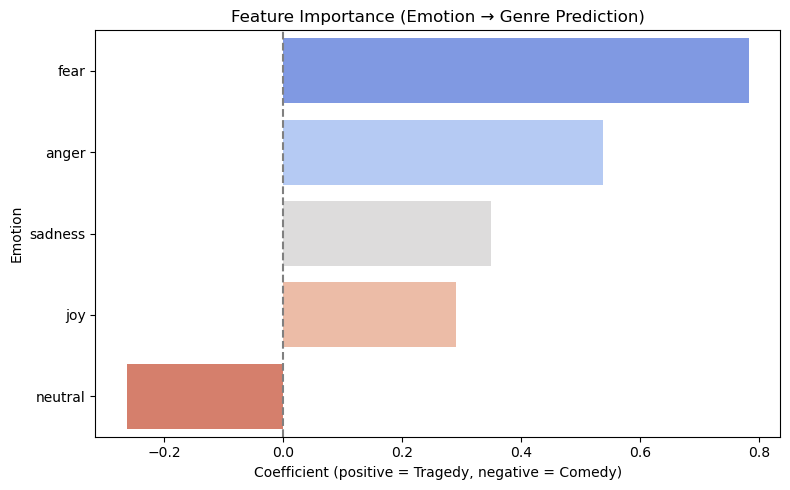

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='coefficient', y='emotion', palette='coolwarm')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Feature Importance (Emotion → Genre Prediction)")
plt.xlabel("Coefficient (positive = Tragedy, negative = Comedy)")
plt.ylabel("Emotion")
plt.tight_layout()
plt.show()


Value	What it means
📈 Positive coefficient	Emotion is more associated with Tragedy
📉 Negative coefficient	Emotion is more associated with Comedy


To understand which emotions most strongly influenced genre classification, we analyzed the logistic regression model coefficients. The results show that fear and anger are the strongest predictors of tragedy, while neutral tone is most aligned with comedies. Interestingly, joy contributes less to comedy classification than expected, suggesting that the absence of negative emotion may be a more reliable indicator of comedic tone.

Breaking down results by act:


- Answer genre-focused questions like:

- How do emotions evolve act-by-act within a play?
- Do tragedies start neutral and end sad?
- Do comedies ramp up joy in the final acts?

In [15]:
melted_df = df.melt(
    id_vars=['play_name', 'act', 'character', 'genre'],
    value_vars=['joy', 'anger', 'fear', 'sadness', 'neutral'],
    var_name='emotion',
    value_name='count'
)


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_play_emotion_by_act(play_name):
    df_plot = melted_df[melted_df['play_name'] == play_name]

    if df_plot.empty:
        print(f"No data found for '{play_name}'")
        return

    # Group by act + emotion (all characters combined)
    grouped = (
        df_plot.groupby(['act', 'emotion'])['count']
        .sum()
        .reset_index()
    )

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grouped, x='act', y='count', hue='emotion', marker='o')
    plt.title(f"Emotion Distribution Across Acts – {play_name}")
    plt.xlabel("Act")
    plt.ylabel("Emotion Count")
    plt.xticks(sorted(df_plot['act'].unique()))
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


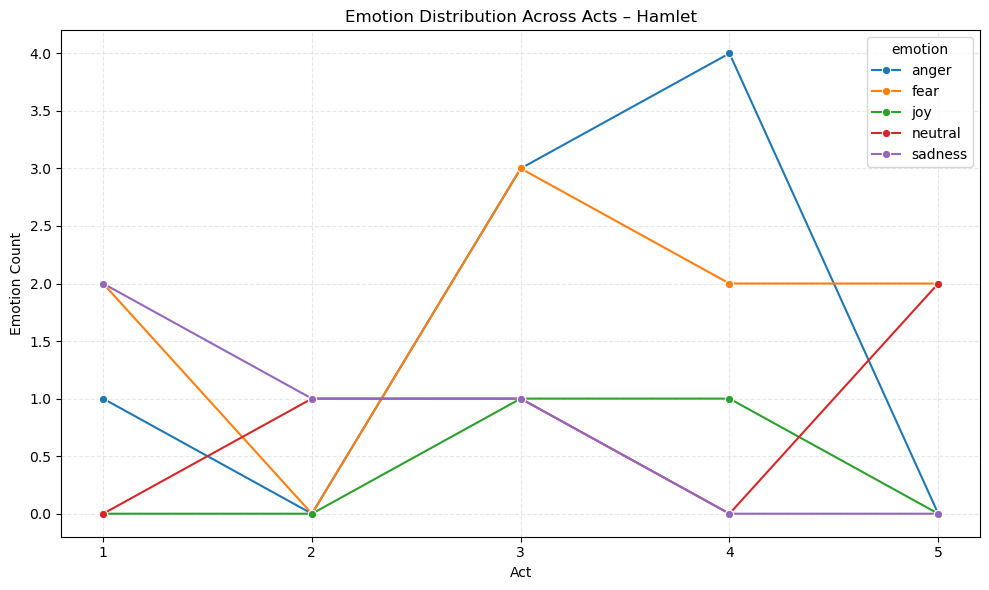

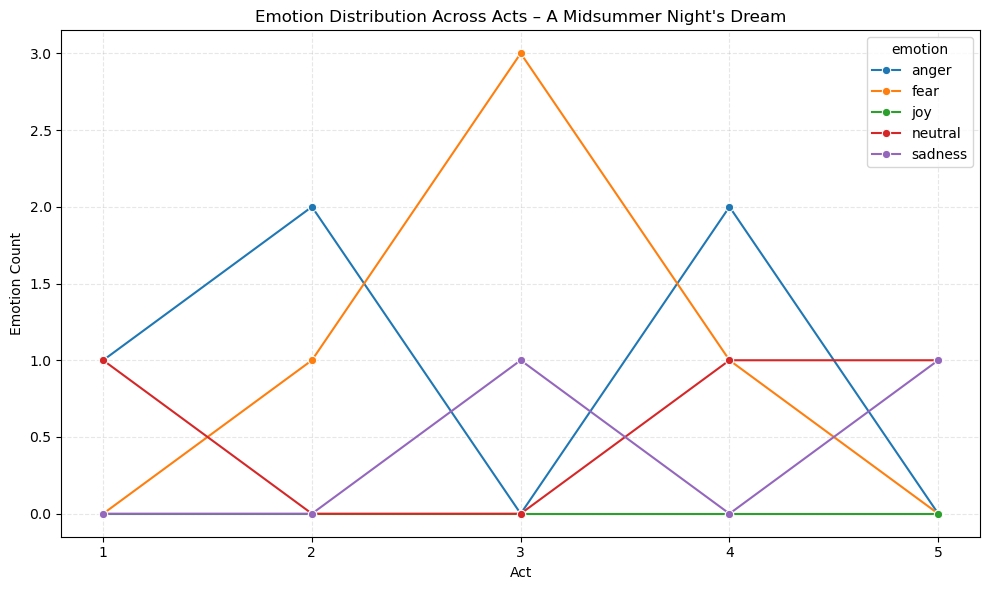

In [17]:
plot_play_emotion_by_act("Hamlet")
plot_play_emotion_by_act("A Midsummer Night's Dream")


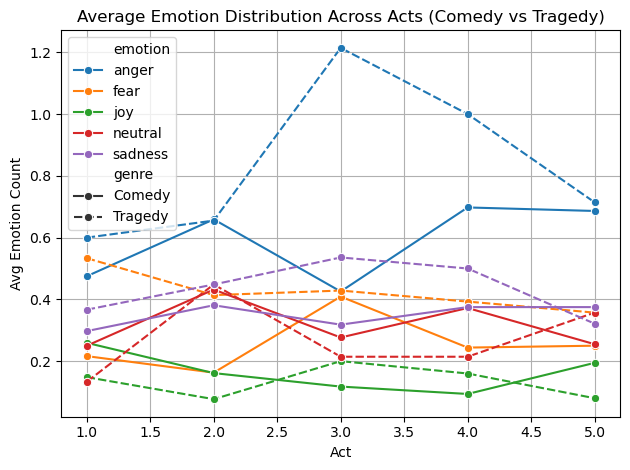

In [18]:
avg_emotions = (
    melted_df.groupby(['genre', 'act', 'emotion'])['count']
    .mean()
    .reset_index()
)

sns.lineplot(data=avg_emotions, x='act', y='count', hue='emotion', style='genre', marker='o')
plt.title("Average Emotion Distribution Across Acts (Comedy vs Tragedy)")
plt.xlabel("Act")
plt.ylabel("Avg Emotion Count")
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
import os

output_dir = "emotion_plots_by_play"
os.makedirs(output_dir, exist_ok=True)


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def save_emotion_plot(play_name, df_long, output_dir):
    df_plot = df_long[df_long['play_name'] == play_name]

    if df_plot.empty:
        print(f"⚠️ No data found for '{play_name}'")
        return

    # Sum all characters per act
    grouped = (
        df_plot.groupby(['act', 'emotion'])['count']
        .sum()
        .reset_index()
    )

    # Create plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grouped, x='act', y='count', hue='emotion', marker='o')
    plt.title(f"Emotion Distribution Across Acts – {play_name}")
    plt.xlabel("Act")
    plt.ylabel("Emotion Count")
    plt.xticks(sorted(df_plot['act'].unique()))
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()

    # Save plot
    filename = f"{output_dir}/{play_name.replace(' ', '_')}_emotion_plot.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close()  # Close to avoid showing in notebook
    print(f"✅ Saved: {filename}")


In [21]:
all_plays = melted_df['play_name'].unique()

for play in all_plays:
    save_emotion_plot(play, melted_df, output_dir)


✅ Saved: emotion_plots_by_play/A_Midsummer_Night's_Dream_emotion_plot.png
✅ Saved: emotion_plots_by_play/All's_Well_That_Ends_Well_emotion_plot.png
✅ Saved: emotion_plots_by_play/As_You_Like_It_emotion_plot.png
✅ Saved: emotion_plots_by_play/Cymbeline_emotion_plot.png
✅ Saved: emotion_plots_by_play/Love's_Labours_Lost_emotion_plot.png
✅ Saved: emotion_plots_by_play/Measure_for_Measure_emotion_plot.png
✅ Saved: emotion_plots_by_play/Much_Ado_About_Nothing_emotion_plot.png
✅ Saved: emotion_plots_by_play/Pericles,_Prince_of_Tyre_emotion_plot.png
✅ Saved: emotion_plots_by_play/Taming_of_the_Shrew_emotion_plot.png
✅ Saved: emotion_plots_by_play/The
Merry_Wives_of_Windsor_emotion_plot.png
✅ Saved: emotion_plots_by_play/The_Comedy_of_Errors_emotion_plot.png
✅ Saved: emotion_plots_by_play/The_Merchant_of_Venice_emotion_plot.png
✅ Saved: emotion_plots_by_play/The_Tempest_emotion_plot.png
✅ Saved: emotion_plots_by_play/Troilus_and_Cressida_emotion_plot.png
✅ Saved: emotion_plots_by_play/Twelfth_

"We visualized act-by-act emotion flows in each play based on the top three characters’ expressions. These plots reveal genre-specific patterns in emotional progression."


In comedies, joy and neutrality often rise in later acts, hinting at resolution and harmony.
In tragedies, emotions like anger, fear, and sadness often intensify toward the end — reinforcing the tragic arc.
These emotional trajectories visually differentiate genres, supporting the findings from your ML classification work.


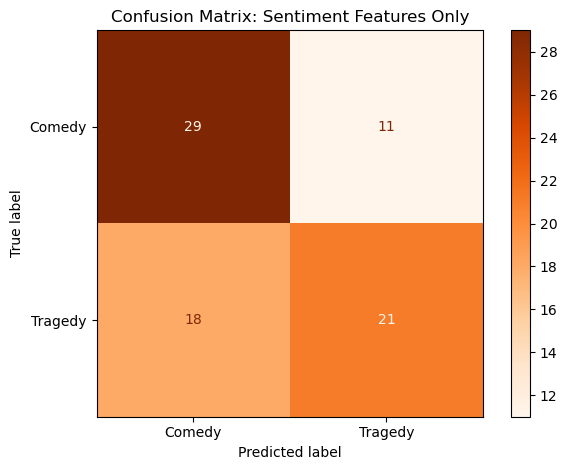

'              precision    recall  f1-score   support\n\n      Comedy       0.62      0.72      0.67        40\n     Tragedy       0.66      0.54      0.59        39\n\n    accuracy                           0.63        79\n   macro avg       0.64      0.63      0.63        79\nweighted avg       0.64      0.63      0.63        79\n'

In [23]:

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

comedy_df['genre'] = 'Comedy'
tragedy_df['genre'] = 'Tragedy'

df_sentiment = pd.concat([comedy_df, tragedy_df], ignore_index=True)

features = ['joy', 'anger', 'fear', 'sadness', 'neutral']
df_sentiment = df_sentiment[features + ['genre']].dropna()

df_sentiment['genre_encoded'] = df_sentiment['genre'].map({'Comedy': 0, 'Tragedy': 1})

X_sent = df_sentiment[features]
y_sent = df_sentiment['genre_encoded']

X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(
    X_sent, y_sent, test_size=0.3, random_state=42, stratify=y_sent
)

model_sent = LogisticRegression(max_iter=1000)
model_sent.fit(X_train_sent, y_train_sent)

y_pred_sent = model_sent.predict(X_test_sent)
report_sent = classification_report(y_test_sent, y_pred_sent, target_names=['Comedy', 'Tragedy'])
conf_matrix_sent = confusion_matrix(y_test_sent, y_pred_sent)

disp_sent = ConfusionMatrixDisplay(conf_matrix_sent, display_labels=['Comedy', 'Tragedy'])
disp_sent.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix: Sentiment Features Only")
plt.tight_layout()
plt.show()

report_sent


With a greater recall for Comedy (72%) than Tragedy (54%), the logistic regression model that was trained solely on emotional characteristics obtained a test accuracy of 63%. This implies that tragic figures have more variance or nuance in affective expression that may not be adequately represented by surface-level emotion frequencies, whereas humorous characters display more unique or consistently modelled emotional tones across acts. Although emotional profiles still offer a significant, if constrained, signal, these results demonstrate that structural traits are a better predictor of genre than sentiment alone when compared to the network-based model (accuracy = 83%).
